In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv(Path('../resources/regressiondata_2018.csv'))
df.head()

,Unnamed: 0,zpid,latestPrice,numOfBathrooms,livingAreaSqFt,numOfBedrooms,avgSchoolRating,numOfStories,MedianStudentsPerTeacher,numOfHighSchools,longitude,numOfPrimarySchools,zipcode,propertyTaxRate,latest_saledate,latest_salemonth,latest_saleyear
0,3,120901374,240000.0,2.0,1678.0,3,2.666667,1,14,1,-97.661659,1,78660,1.98,2018-08-08,8,2018
1,4,60134862,239900.0,3.0,2132.0,3,4.000000,2,14,1,-97.656860,1,78660,1.98,2018-10-31,10,2018
2,7,60134835,219900.0,3.0,1422.0,3,4.000000,2,14,1,-97.658035,1,78660,1.98,2018-10-10,10,2018
3,9,83827468,194800.0,3.0,1422.0,3,3.000000,2,14,1,-97.638123,1,78617,1.98,2018-09-11,9,2018
4,13,64520966,200000.0,2.0,1326.0,3,3.000000,1,14,1,-97.650581,1,78617,1.98,2018-12-15,12,2018


In [3]:
df.columns

Index(['Unnamed: 0', 'zpid', 'latestPrice', 'numOfBathrooms', 'livingAreaSqFt',
       'numOfBedrooms', 'avgSchoolRating', 'numOfStories',
       'MedianStudentsPerTeacher', 'numOfHighSchools', 'longitude',
       'numOfPrimarySchools', 'zipcode', 'propertyTaxRate', 'latest_saledate',
       'latest_salemonth', 'latest_saleyear'],
      dtype='object')

In [4]:
# Save 'zpid'
id_df = df['zpid']

# Drop 'zpid' column
df.drop(["zpid","latest_saledate","Unnamed: 0",'latest_salemonth','latest_saleyear'], axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nData size: {} ".format(df.shape)) 


Data size: (4394, 12) 


In [5]:
# Create features and target
y = df["latestPrice"]
X = df.drop(columns=['latestPrice'])

In [6]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape

(3295, 11)

In [7]:
# Create DMatrices

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 238359.38


In [9]:
# Create parameters dictionary
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [10]:
params['eval_metric'] = "mae"

num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mae:363742
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:265091
[2]	Test-mae:200262
[3]	Test-mae:164187
[4]	Test-mae:142278
[5]	Test-mae:130053
[6]	Test-mae:123156
[7]	Test-mae:120212
[8]	Test-mae:118205
[9]	Test-mae:117064
[10]	Test-mae:115436
[11]	Test-mae:115406
[12]	Test-mae:114498
[13]	Test-mae:113060
[14]	Test-mae:112377
[15]	Test-mae:112288
[16]	Test-mae:111570
[17]	Test-mae:110513
[18]	Test-mae:110127
[19]	Test-mae:109424
[20]	Test-mae:109504
[21]	Test-mae:108692
[22]	Test-mae:108525
[23]	Test-mae:108430
[24]	Test-mae:108310
[25]	Test-mae:108119
[26]	Test-mae:108098
[27]	Test-mae:107589
[28]	Test-mae:107329
[29]	Test-mae:107117
[30]	Test-mae:107090
[31]	Test-mae:107043
[32]	Test-mae:106805
[33]	Test-mae:106984
[34]	Test-mae:106963
[35]	Test-mae:107449
[36]	Test-mae:107446
[37]	Test-mae:107602
[38]	Test-mae:107752
[39]	Test-mae:107765
[40]	Test-mae:107804
[41]	Test-mae:107455
[42]	Test-mae:107679
Stopping. Best iteration:
[32]	Test-mae:106805

Bes

In [12]:
# Get cross validation score with current params
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,338152.287500,3763.042115,340431.787500,17833.547391
1,241570.668750,2893.270482,246056.215625,15767.137852
2,177488.387500,2080.531566,185523.881250,14431.646324
3,136536.784375,1900.353914,149241.914062,13771.146991
4,112340.401562,1827.552093,128261.468750,13241.684949
5,98765.332812,2155.877414,117874.918750,12099.410681
6,91374.381250,2271.119653,112465.164062,11649.552460
7,86815.990625,2164.912092,109500.931250,11467.253191
8,83658.192188,1952.081379,108131.698437,11222.173178
9,81488.843750,2278.463799,107328.117187,10787.111464


In [13]:
cv_results['test-mae-mean'].min()

100389.828125

In [14]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,12)
    for min_child_weight in range(1,10)
]

In [15]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, min_child_weight=1
	MAE 100104.5296874 for 63 rounds
CV with max_depth=4, min_child_weight=2
	MAE 102427.4578124 for 63 rounds
CV with max_depth=4, min_child_weight=3
	MAE 101476.0937502 for 65 rounds
CV with max_depth=4, min_child_weight=4
	MAE 103823.2734376 for 76 rounds
CV with max_depth=4, min_child_weight=5
	MAE 103904.25625 for 116 rounds
CV with max_depth=4, min_child_weight=6
	MAE 104600.184375 for 77 rounds
CV with max_depth=4, min_child_weight=7
	MAE 103449.9828124 for 85 rounds
CV with max_depth=4, min_child_weight=8
	MAE 103964.4765624 for 102 rounds
CV with max_depth=4, min_child_weight=9
	MAE 106915.478125 for 79 rounds
CV with max_depth=5, min_child_weight=1
	MAE 99953.10312479999 for 39 rounds
CV with max_depth=5, min_child_weight=2
	MAE 102053.925 for 62 rounds
CV with max_depth=5, min_child_weight=3
	MAE 101975.2281252 for 67 rounds
CV with max_depth=5, min_child_weight=4
	MAE 103784.446875 for 62 rounds
CV with max_depth=5, min_child_weight=5
	M

In [16]:
# Update parameters with best found parameters
params['max_depth'] = 7
params['min_child_weight'] = 1

In [17]:
# Tuning 'subsample' and 'colsample_bytree' parameters
# Create list of possible params
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [18]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 100325.74375 for 35 rounds
CV with subsample=1.0, colsample=0.9
	MAE 98847.4203124 for 33 rounds
CV with subsample=1.0, colsample=0.8
	MAE 101289.7140626 for 38 rounds
CV with subsample=1.0, colsample=0.7
	MAE 101820.8796872 for 29 rounds
CV with subsample=0.9, colsample=1.0
	MAE 101576.8062502 for 36 rounds
CV with subsample=0.9, colsample=0.9
	MAE 101714.41875 for 37 rounds
CV with subsample=0.9, colsample=0.8
	MAE 100650.9687502 for 27 rounds
CV with subsample=0.9, colsample=0.7
	MAE 100872.4421872 for 37 rounds
CV with subsample=0.8, colsample=1.0
	MAE 104483.0359376 for 25 rounds
CV with subsample=0.8, colsample=0.9
	MAE 100635.9765624 for 27 rounds
CV with subsample=0.8, colsample=0.8
	MAE 102096.61562520001 for 27 rounds
CV with subsample=0.8, colsample=0.7
	MAE 101091.8 for 30 rounds
CV with subsample=0.7, colsample=1.0
	MAE 101569.1859376 for 28 rounds
CV with subsample=0.7, colsample=0.9
	MAE 99807.55 for 37 rounds
CV with subsample=0

In [19]:
# Update params dictionary
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

In [20]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 101714.41250040001 for 37 rounds

CV with eta=0.2
	MAE 97821.5953124 for 47 rounds

CV with eta=0.1
	MAE 96518.9359374 for 106 rounds

CV with eta=0.05
	MAE 96245.3015624 for 225 rounds

CV with eta=0.01
	MAE 95847.1890624 for 996 rounds

CV with eta=0.005
	MAE 97767.13437479999 for 998 rounds

Best params: 0.01, MAE: 95847.1890624


In [21]:
# Update parameters dictionary
params['eta'] = .05

In [22]:
params

{'max_depth': 7,
 'min_child_weight': 1,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.9,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [23]:
# Train the model with the tuned parameters and use test data
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:481945
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:459079
[2]	Test-mae:437443
[3]	Test-mae:416495
[4]	Test-mae:397220
[5]	Test-mae:378857
[6]	Test-mae:361350
[7]	Test-mae:344539
[8]	Test-mae:328513
[9]	Test-mae:313782
[10]	Test-mae:299502
[11]	Test-mae:286147
[12]	Test-mae:273561
[13]	Test-mae:260923
[14]	Test-mae:249426
[15]	Test-mae:238434
[16]	Test-mae:228346
[17]	Test-mae:219075
[18]	Test-mae:210024
[19]	Test-mae:201918
[20]	Test-mae:194366
[21]	Test-mae:187361
[22]	Test-mae:180746
[23]	Test-mae:174865
[24]	Test-mae:169154
[25]	Test-mae:163934
[26]	Test-mae:158878
[27]	Test-mae:154683
[28]	Test-mae:150418
[29]	Test-mae:146614
[30]	Test-mae:143086
[31]	Test-mae:139795
[32]	Test-mae:136757
[33]	Test-mae:133866
[34]	Test-mae:131188
[35]	Test-mae:128991
[36]	Test-mae:127021
[37]	Test-mae:124993
[38]	Test-mae:123006
[39]	Test-mae:121046
[40]	Test-mae:119116
[41]	Test-mae:117750
[42]	Test-mae:116602
[43]	Test-mae:115377
[44]	Test-mae:114506
[45]	Test

In [24]:
# Save model with best parameters
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:481945
[1]	Test-mae:459079
[2]	Test-mae:437443
[3]	Test-mae:416495
[4]	Test-mae:397220
[5]	Test-mae:378857
[6]	Test-mae:361350
[7]	Test-mae:344539
[8]	Test-mae:328513
[9]	Test-mae:313782
[10]	Test-mae:299502
[11]	Test-mae:286147
[12]	Test-mae:273561
[13]	Test-mae:260923
[14]	Test-mae:249426
[15]	Test-mae:238434
[16]	Test-mae:228346
[17]	Test-mae:219075
[18]	Test-mae:210024
[19]	Test-mae:201918
[20]	Test-mae:194366
[21]	Test-mae:187361
[22]	Test-mae:180746
[23]	Test-mae:174865
[24]	Test-mae:169154
[25]	Test-mae:163934
[26]	Test-mae:158878
[27]	Test-mae:154683
[28]	Test-mae:150418
[29]	Test-mae:146614
[30]	Test-mae:143086
[31]	Test-mae:139795
[32]	Test-mae:136757
[33]	Test-mae:133866
[34]	Test-mae:131188
[35]	Test-mae:128991
[36]	Test-mae:127021
[37]	Test-mae:124993
[38]	Test-mae:123006
[39]	Test-mae:121046
[40]	Test-mae:119116
[41]	Test-mae:117750
[42]	Test-mae:116602
[43]	Test-mae:115377
[44]	Test-mae:114506
[45]	Test-mae:113656
[46]	Test-mae:112781
[47]	Test-mae:112015
[4

In [25]:
# Create prediction
y_pred = best_model.predict(dtest)

In [26]:
# Save model
best_model.save_model("xgboost_optimal_2018.model")

In [27]:
# Calculate R squared and Adjusted R Square
import statsmodels.api as sm
result = sm.OLS(y_pred, y_test).fit()
print(result.rsquared, result.rsquared_adj)

0.8240249941656208 0.8238647254899976


In [28]:
# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import math
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_squared_log_error(y_test, y_pred))

85423575246.96721
292273.1175578199
0.07008286279559428


In [29]:
# Calculate Mean Absolute Error(MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

105503.719716788


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

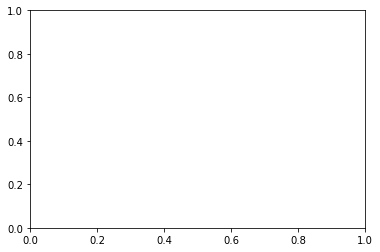

In [30]:
import matplotlib.pyplot as plt

# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/danny/.conda/envs/mlenv/lib/site-packages/graphviz'

xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
# # Code to load model for other datasets:
# loaded_model = xgb.Booster()
# loaded_model.load_model("my_model.model")
# # And use it for predictions.
# loaded_model.predict(dtest)